In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import math

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('/content/drive/MyDrive/NUS FinTech/data.csv', index_col = 0, parse_dates=True)
test = pd.read_csv('/content/drive/MyDrive/NUS FinTech/sample_submission.csv', index_col = 0, parse_dates = True)

In [3]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2010-09-13,15400,15519,15320,15400,234851
2010-09-14,15500,15620,15200,15200,371530
2010-09-15,15260,15340,15020,15140,389289
2010-09-16,15080,15260,15080,15140,234815
2010-09-17,15240,15560,15159,15460,447649
...,...,...,...,...,...
2017-04-06,42000,42080,41600,41840,193668
2017-04-07,41800,41820,41160,41600,200420
2017-04-10,41940,41940,41500,41940,142827


In [4]:
test

,Predicted
Date,
2017-04-13,0
2017-04-14,0
2017-04-17,0
2017-04-18,0
2017-04-19,0
...,...
2021-09-07,0
2021-09-08,0
2021-09-09,0


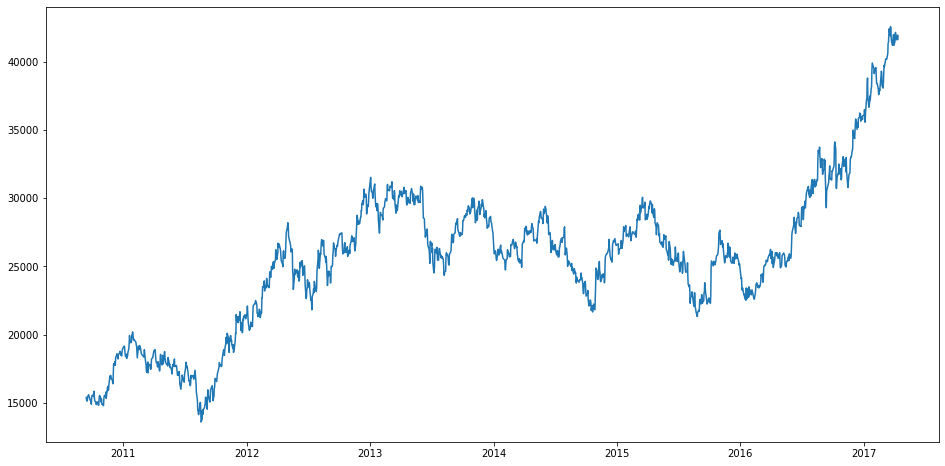

In [5]:
plt.figure(figsize = (16,8))
plt.plot(df['Close'])

Based on the plot of the opening prices, it looks like there is a clear trend, and the data is not stationary.

In [6]:
df['first_diff'] = df['Close'].diff()

In [7]:
df.dropna(inplace = True)

In [8]:
df

,Open,High,Low,Close,Volume,first_diff
Date,,,,,,
2010-09-14,15500,15620,15200,15200,371530,-200.0
2010-09-15,15260,15340,15020,15140,389289,-60.0
2010-09-16,15080,15260,15080,15140,234815,0.0
2010-09-17,15240,15560,15159,15460,447649,320.0
2010-09-20,15480,15599,15400,15600,296452,140.0
...,...,...,...,...,...,...
2017-04-06,42000,42080,41600,41840,193668,-300.0
2017-04-07,41800,41820,41160,41600,200420,-240.0
2017-04-10,41940,41940,41500,41940,142827,340.0


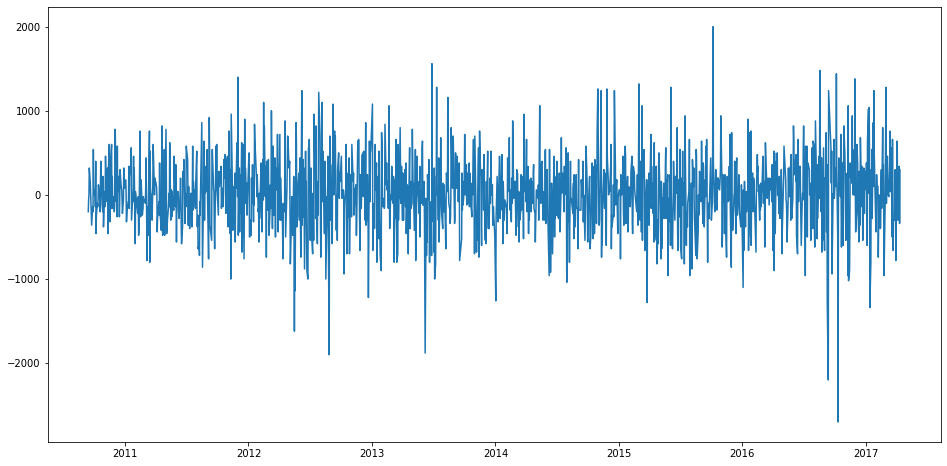

In [9]:
# plot the first diff values
plt.figure(figsize = (16,8))
plt.plot(df['first_diff'])

The first differenced values look stationary based on the plot. Hence d = 1 for the ARIMA model. I will use the adf test to confirm the stationarity

In [10]:
#use adfuller on the differenced data
adfuller(df['first_diff'])

(-26.443846853859448,
 0.0,
 2,
 1624,
 {'1%': -3.4343830457666806,
  '10%': -2.5677183557141645,
  '5%': -2.8633213561112156},
 23996.81374455557)

The p-value is the second element in the tuple that is returned, and it shows that the p-value is < 0.05, so we can reject the null hypothesis that the time-series is not stationary

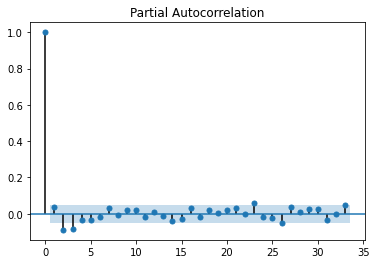

In [11]:
plot_pacf(df['first_diff'])
plt.show()

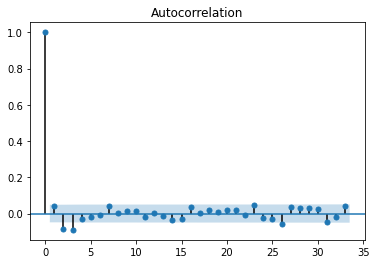

In [12]:
plot_acf(df['first_diff'])
plt.show()

## Model 1: ARIMA(1,1,1)

**Based on the ACF and PACF plots, there is a sharp decline in both acf and pacf after the first lag. Hence I would try use AR(1) and MA(1), along with I = 1 due to first differencing**

In [18]:
#train-val ratio is 80-20
size = int(len(df) * 0.8)

In [19]:
train, val = df[:size], df[size:]

In [20]:
train

,Open,High,Low,Close,Volume,first_diff
Date,,,,,,
2010-09-14,15500,15620,15200,15200,371530,-200.0
2010-09-15,15260,15340,15020,15140,389289,-60.0
2010-09-16,15080,15260,15080,15140,234815,0.0
2010-09-17,15240,15560,15159,15460,447649,320.0
2010-09-20,15480,15599,15400,15600,296452,140.0
...,...,...,...,...,...,...
2015-12-09,25240,25500,25240,25260,181812,20.0
2015-12-10,25260,25860,25260,25660,303867,400.0
2015-12-11,25660,25900,25440,25680,206729,20.0


In [29]:
model = ARIMA(train['Close'], order = (1,1,1))
model_fit = model.fit()
pred = model_fit.forecast(steps = len(val))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [30]:
forecast_array = pred[0]

In [31]:
forecast_series = pd.Series(forecast_array, index = val.index)

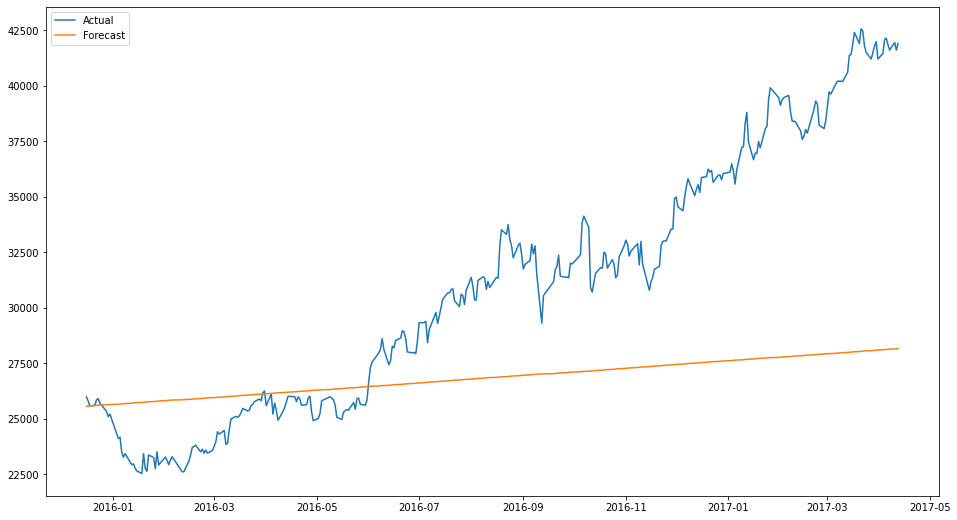

In [32]:
plt.figure(figsize = (16,9))
plt.plot(val['Close'])
plt.plot(forecast_series)
plt.legend(['Actual', 'Forecast'])

In [34]:
rmse = math.sqrt(mean_squared_error(forecast_array, val['Close']))
print(rmse)

6474.75678211343


## Model 2: ARIMA(1,1,0)

**Since both ACF and PACF plot shows a sharp drop at lag = 1, I will try just the AR(1) model, together with I = 1, and ignore the MA part**

In [35]:
model_2 = ARIMA(train['Close'], order = (1,1,0))
model_2_fit = model_2.fit()
pred_2 = model_2_fit.forecast(steps = len(val))


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [39]:
forecast_array_2 = pred_2[0]

In [40]:
forecast_series_2 = pd.Series(forecast_array_2, index = val.index)

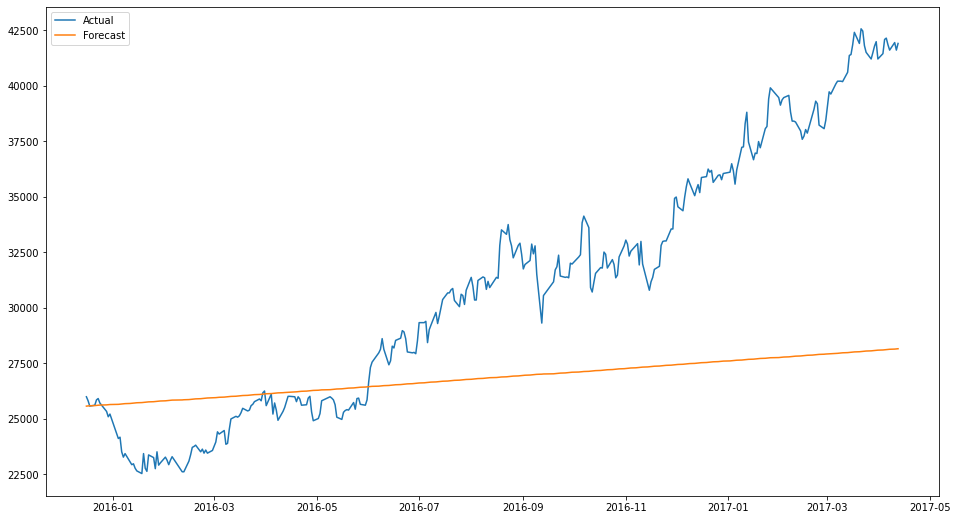

In [41]:
plt.figure(figsize = (16,9))
plt.plot(val['Close'])
plt.plot(forecast_series_2)
plt.legend(['Actual', 'Forecast'])

In [42]:
rmse = math.sqrt(mean_squared_error(forecast_array, val['Close']))
print(rmse)

6479.679358860649


## Model 3: ARIMA(0,1,1)

**Since both ACF and PACF plot shows a sharp drop at lag = 1, I will try just the MA(1) model, together with I = 1, and ignore the AR part**

In [43]:
model_3 = ARIMA(train['Close'], order = (0,1,1))
model_3_fit = model_3.fit()
pred_3 = model_3_fit.forecast(steps = len(val))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [44]:
forecast_array_3 = pred_3[0]

In [45]:
forecast_series_3 = pd.Series(forecast_array_3, index = val.index)

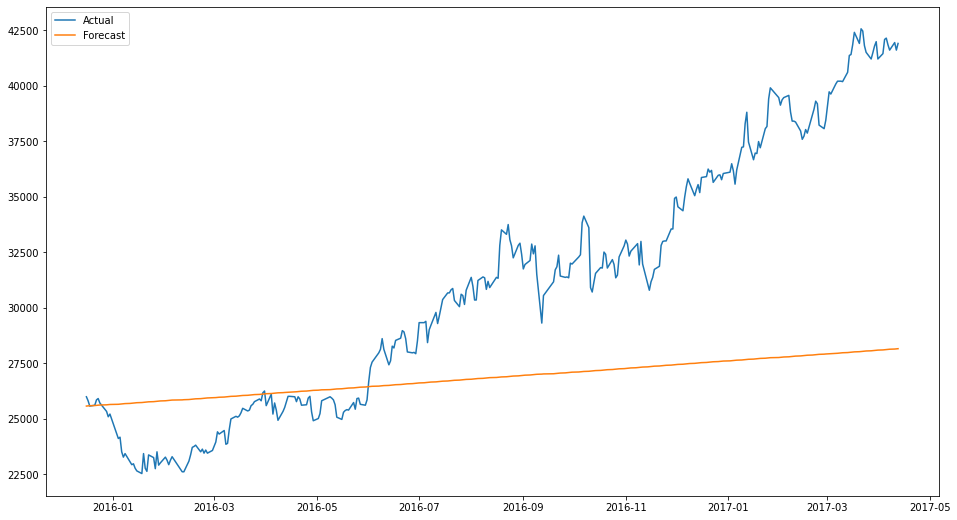

In [46]:
plt.figure(figsize = (16,9))
plt.plot(val['Close'])
plt.plot(forecast_series_3)
plt.legend(['Actual', 'Forecast'])

In [48]:
rmse = math.sqrt(mean_squared_error(forecast_array_3, val['Close']))
print(rmse)

6478.213439255789


## Final Model: ARIMA(1,1,1)


**Based on the RMSE calculated from comparing the validation set together with the predicted output, the lowest RMSE, which is correspondingly the best model would be ARIMA(1,1,1), hence I will be using this model for the final predictions**

In [49]:
model_final = ARIMA(df['Close'], order = (1,1,1))
final_model = model_final.fit()
pred_final = final_model.forecast(steps = len(test))
y_hat = pred_final[0]

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [50]:
y_hat

array([41913.0002307 , 41926.73825897, 41941.05470308, ...,
       59678.68537224, 59695.10095847, 59711.5165447 ])

In [51]:
test['Predicted'] = y_hat

In [52]:
test

,Predicted
Date,
2017-04-13,41913.000231
2017-04-14,41926.738259
2017-04-17,41941.054703
2017-04-18,41955.824612
2017-04-19,41970.950025
...,...
2021-09-07,59645.854200
2021-09-08,59662.269786
2021-09-09,59678.685372


In [56]:
from google.colab import drive
drive.mount('/drive')


Mounted at /drive


In [59]:
test.to_csv('/drive/MyDrive/NUS FinTech/output.csv')